# Assess Solvation Energies
Compare the ExaMol solvation energies to those [from our recent work with Gaussian](https://pubs.acs.org/doi/abs/10.1021/acs.jpca.1c01960).

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.stats import pearsonr, kendalltau
from foundry import Foundry
from pathlib import Path
from ase import units
import pandas as pd

/home/lward/miniconda3/envs/examol/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load in the Baseline and ExaMol results
The baseline is our QM9-based dataset and the ExaMol is stored on disk

In [2]:
client = Foundry(force_login=True)
client.load('10.18126/jos5-wj65', globus=False)
baseline = pd.concat(client.load_data()['train'], axis=1)

In [3]:
baseline.rename(columns={'smiles_1': 'smiles'}, inplace=True)

Load the CP2K, which are stored per-calculation. We'll need to compute IE ourselves

In [4]:
examol_solvent = pd.concat([
    pd.read_json(path, lines=True).drop(columns=['result'])
    for path in Path().glob('**/solvation.json')
])
print(f'Loaded {len(examol_solvent)} calculations of {len(set(examol_solvent.filename))} molecules')

Loaded 24579 calculations of 3405 molecules


In [5]:
examol_vacuum = pd.concat([
    pd.read_json(path, lines=True).drop(columns=['result'])
    for path in Path().glob('**/output.json')
])
print(f'Loaded {len(examol_vacuum)} calculations of {len(set(examol_vacuum.filename))} molecules')

Loaded 30620 calculations of 3405 molecules


Merge them 

In [6]:
examol_data = examol_solvent.merge(examol_vacuum, on=['config_name', 'charge', 'filename', 'smiles'], suffixes=['_solvent', '_vacuum'])

In [7]:
examol_data['G_solv'] = (examol_data['energy_solvent'] - examol_data['energy_vacuum']) * units.mol / units.kcal

## Compare to PCM
Compare each of configurations we've run with ExaMol

In [8]:
total_configs = len(set(examol_data.config_name))

cp2k_blyp_dzvp 1.3283107620712908
cp2k_blyp_szv 3.2096861533143715
cp2k_blyp_tzvp 4.479439828128472
gaussian_b3lyp_6-31g(2df,p) 0.5719700425791825


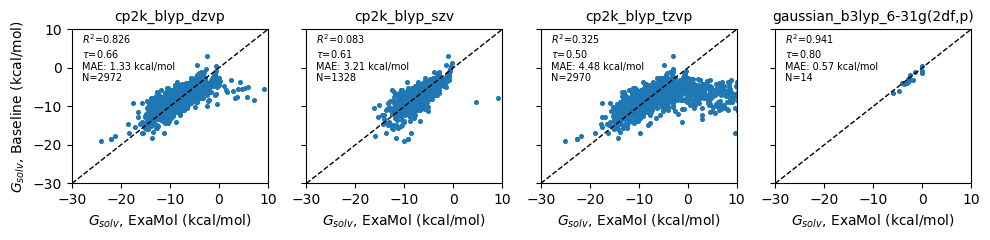

In [9]:
fig, axs = plt.subplots(1, total_configs, sharey=True, figsize=(total_configs * 2.5, 2.5))

for ax, (gid, group) in zip(axs, examol_data.query('charge==0').groupby('config_name')):
    ax.set_title(gid, fontsize=10)
    
    # Plot the data
    merged = group.merge(baseline, on=['smiles'])
    r2 = pearsonr(merged['G_solv'], merged['sol_acn'])
    tau = kendalltau(merged['G_solv'], merged['sol_acn'])
    offset = (merged['G_solv'] - merged['sol_acn']).mean()
    mae = ((merged['G_solv'] - merged['sol_acn']) - offset).abs().mean()
    print(gid, mae)
    ax.scatter(merged['G_solv'], merged['sol_acn'], s=7)
    ax.text(0.05, 0.98, f'$R^2$={r2[0]:.3f}\n$\\tau$={tau[0]:.2f}\nMAE: {mae :.2f} kcal/mol\nN={len(merged)}', 
           transform=ax.transAxes, va='top', fontsize=7)
    
    # Plot y=x
    ax.set_xlim(-30, 10)
    ax.set_ylim(ax.get_xlim())
    ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--', lw=1)

    ax.set_xlabel('$G_{solv}$, ExaMol (kcal/mol)')

axs[0].set_ylabel('$G_{solv}$, Baseline (kcal/mol)')
fig.tight_layout()
fig.savefig('figures/solvation-energy-validation.png', dpi=320)